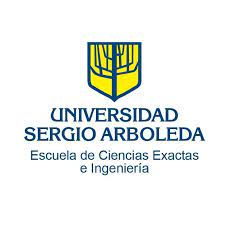

# **Programa de Ciencias de la Computación e Inteligencia Artificial**
---

### **Parcial Final**
> **Profesor**: John Jairo Corredor Franco

> **Autor**: Carlos Alberto Arévalo Martínez

> **Fecha**: 23 de Mayo de 2022

> **Materia**: High Performance Computing 03 (HPC-03)

In [ ]:
# Se importan las bibliotecas necesarias (libraries)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from IPython.core.pylabtools import figsize
from sklearn.metrics import r2_score

In [ ]:
# Se importan los resultados obtenidos en el modelo implementado
# en C++ (modelo de regresión lineal)
costoCpp_train = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/LRModeloVF/Debug/vectorCosto_train.txt", header=None)
thetaCpp_train = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/LRModeloVF/Debug/vectorTheta_train.txt", header=None)
y_hatCpp_train = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/LRModeloVF/Debug/prediccion_train.txt", header=None)
costoCpp_test = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/LRModeloVF/Debug/vectorCosto_test.txt", header=None)
thetaCpp_test = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/LRModeloVF/Debug/vectorTheta_test.txt", header=None)
y_hatCpp_test = pd.read_csv("https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/LRModeloVF/Debug/prediccion_test.txt", header=None)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Neftcode/CCIA/main/HPC03/Parcial_III/LRModeloVF/DATASETS/californiaHousingHPC_withheader.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1925.0000,65500.0


### A continuación, se realiza el EDA (Análisis exploratorio de los datos)

In [ ]:
# 1.- Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            16999 non-null  float64
 2   housing_median_age  16998 non-null  float64
 3   total_rooms         16998 non-null  float64
 4   total_bedrooms      16999 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [ ]:
# 2.- Se observa un resumen estadístico de los datos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,17000.0,-119.562108,2.005166,-124.3500,-121.7900,-118.49,-118.000,-114.31
latitude,16999.0,35.625311,2.137373,32.5400,33.9300,34.25,37.720,41.95
housing_median_age,16998.0,28.591717,12.585593,1.0000,18.0000,29.00,37.000,52.00
total_rooms,16998.0,2643.287857,2179.244192,2.0000,1462.0000,2127.00,3150.750,37937.00
total_bedrooms,16999.0,539.425260,421.507647,1.0000,297.0000,434.00,648.500,6445.00
population,17000.0,1429.573941,1147.852959,3.0000,790.0000,1167.00,1721.000,35682.00
households,17000.0,501.221941,384.520841,1.0000,282.0000,409.00,605.250,6082.00
median_income,17000.0,385.417016,1276.462977,0.4999,2.6618,3.75,5.423,13947.00
median_house_value,17000.0,207300.912353,115983.764387,14999.0000,119400.0000,180400.00,265000.000,500001.00


Se decide imputar los datos faltantes con los vecinos más cercanos (KNN), de las columnas: **latitude**, **housing_median_age**, **total_rooms**, **total_bedrooms**


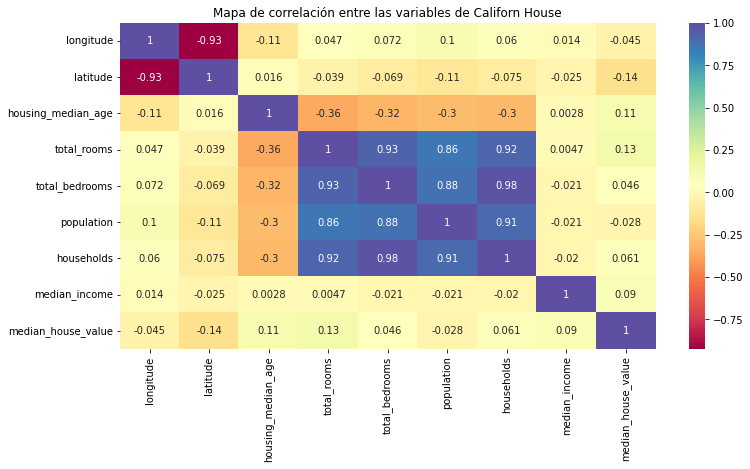

In [ ]:
# 3.- A continuación, se presenta la matriz de correlación: Representa
# el grado de afinidad entre las variables. Si el Factor es cercano a
# 1 o -1, representa una alta afinidad o relación (directa o indirectamente
# proporcional)
mathCorr = df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(mathCorr, annot=True, cmap='Spectral')
plt.title('Mapa de correlación entre las variables de Californ House')
plt.show()

Dada esa matriz de correlación, se presume que no hay una relación inversamente proporcional entre la variable dependiente e independientes, por lo tanto, se evidencia que presenta una relación significativamente baja.

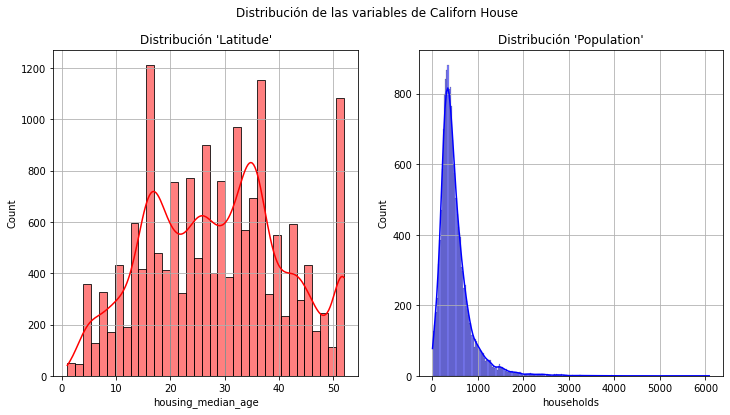

In [ ]:
# 4.- A continuación, se presenta la distribución de las variables
# (se espera que la distribución de todas las varibales sea Normal-Gaussiana)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Distribución de las variables de Californ House')
sns.histplot(df['housing_median_age'], kde=True, color='r', ax=axes[0])
sns.histplot(df['households'], kde=True, color='b', ax=axes[1])
axes[0].grid()
axes[0].set_title("Distribución 'Latitude'")
axes[1].grid()
axes[1].set_title("Distribución 'Population'")
plt.show()

Se puede apreciar que las variables no presentan una distribución 'normal'. Por ende se procede a aplicar **PowerTransformer** que hace que los datos sean más gaussianos.


In [ ]:
# Se separa en 2 grupos: variables dependientes e independientes
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']

A continuación, se dividen los datos en 2 grupos: prueba y entrenamiento (test, train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)

In [ ]:
# Se selecciona el modelo de Machine Learning: En un Pipeline
pipe = Pipeline([('Imputer', KNNImputer(n_neighbors=5)),
                 ('Scaler', StandardScaler()),
                 ('Gaussian', PowerTransformer(method='yeo-johnson', standardize=True)), 
                 ('ModelLR', LinearRegression())])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('Imputer', KNNImputer()), ('Scaler', StandardScaler()),
                ('Gaussian', PowerTransformer()),
                ('ModelLR', LinearRegression())])

In [ ]:
# Se toman los valores de predicción de entrenamiento
y_hatSk_train = pipe.predict(X_train)

In [ ]:
# Se toman los valores de predicción de prueba
y_hatSk_test = pipe.predict(X_test)

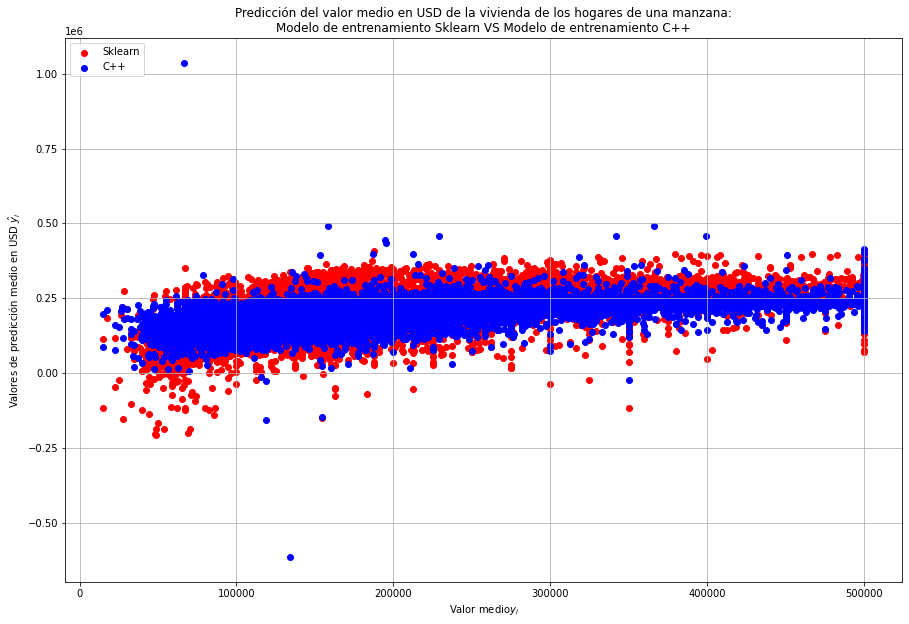

In [ ]:
# Se presentan las gráficas de predicciones de entrenamiento entre el 
# modelo C++ y el modelo Sklearn
fig, axes = plt.subplots(figsize=(15, 10))
plt.scatter(y_train, y_hatSk_train, c='r', label='Sklearn')
plt.scatter(y_train, y_hatCpp_train, c='b', label='C++')
plt.legend(loc=2)
plt.grid()
plt.title('Predicción del valor medio en USD de la vivienda de los hogares de una manzana:\nModelo de entrenamiento Sklearn VS Modelo de entrenamiento C++')
plt.xlabel('Valor medio$y_i$')
plt.ylabel('Valores de predicción medio en USD $\hat{y_i}$')
plt.show()

In [ ]:
r2Sk_train = r2_score(y_train, y_hatSk_train)
r2Cpp_train = r2_score(y_train, y_hatCpp_train)
print(f'Métrica de rendimiento sk (r2_score) {r2Sk_train}')
print(f'Métrica de rendimiento sk (r2_score) {r2Cpp_train}')

Métrica de rendimiento sk (r2_score) 0.39381994752516714
Métrica de rendimiento sk (r2_score) 0.2842862723041031


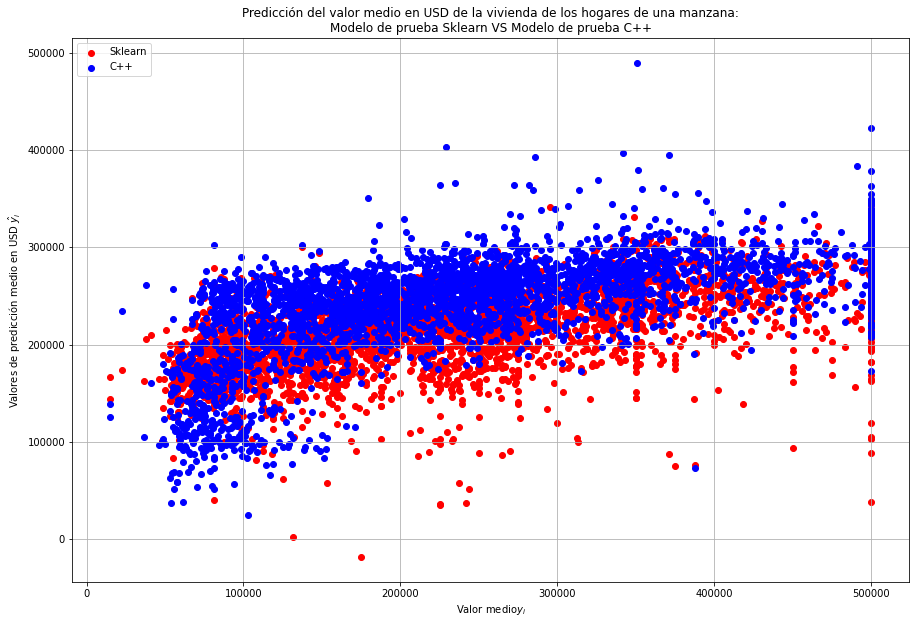

In [ ]:
# Se presentan las gráficas de predicciones de prueba entre el 
# modelo C++ y el modelo Sklearn
fig, axes = plt.subplots(figsize=(15, 10))
plt.scatter(y_test, y_hatSk_test, c='r', label='Sklearn')
plt.scatter(y_test, y_hatCpp_test, c='b', label='C++')
plt.legend(loc=2)
plt.grid()
plt.title('Predicción del valor medio en USD de la vivienda de los hogares de una manzana:\nModelo de prueba Sklearn VS Modelo de prueba C++')
plt.xlabel('Valor medio$y_i$')
plt.ylabel('Valores de predicción medio en USD $\hat{y_i}$')
plt.show()

In [ ]:
r2Sk_test = r2_score(y_test, y_hatSk_test)
r2Cpp_test = r2_score(y_test, y_hatCpp_test)
print(f'Métrica de rendimiento sk (r2_score) {r2Sk_test}')
print(f'Métrica de rendimiento sk (r2_score) {r2Cpp_test}')

Métrica de rendimiento sk (r2_score) 0.24236008799867514
Métrica de rendimiento sk (r2_score) 0.33697672939037493
